E:\Jupyter\virtualenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\Spider\AppData\Local\Temp\ipykernel_9340\4072753276.py:6: FutureWarning: 

All support for the `google.generativeai` package has ended. It will no longer be receiving 
updates or bug fixes. Please switch to the `google.genai` package as soon as possible.
See README for more details:

https://github.com/google-gemini/deprecated-generative-ai-python/blob/main/README.md

  import google.generativeai as genai


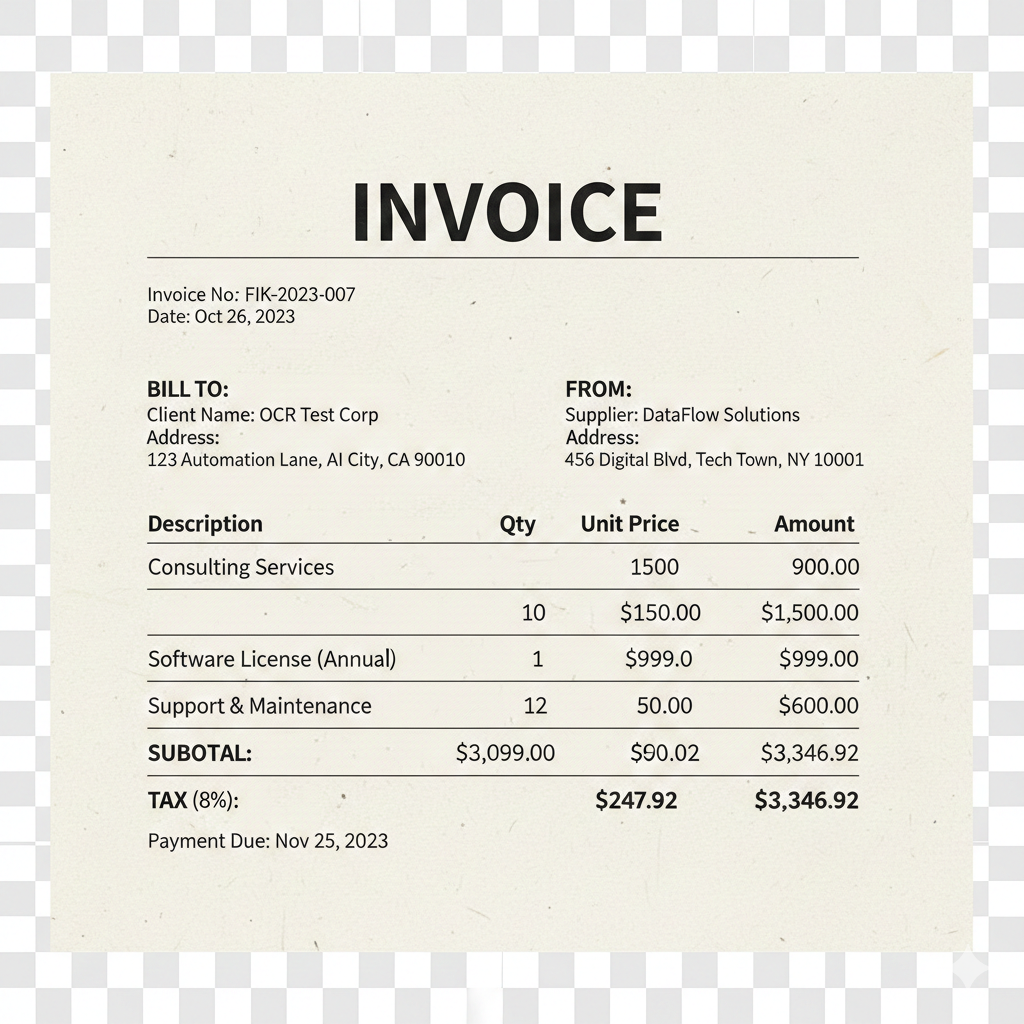

Raw OCR Output:
INVOICE

Invoice No: FIK-2023-007
Date: Oct 26, 2023

BILLTO:
Client Name: OCR Test Corp
Address:

123 Automation Lane, Al City, CA 90010

FROM:

Supplier: DataFlow Solutions

Address:

456 Digital Blvd, Tech Town, NY 10001

Unit Price

Description Qty Amount
Consulting Services 1500 900.00

10 $150.00 $1,500.00
Software License (Annual) ‘lL $999.0 $999.00
Support & Maintenance 12 50.00 $600.00
SUBOTAL: $3,099.00 $90.02 $3,346.92
TAX (8%): $247.92 $3,346.92

Payment Due: Nov 25, 2023


REGEX EXTRACTION
Tax: $247.92
Total: $3,346.92

GEMINI LLM EXTRACTION
Using model: models/gemini-2.5-flash

Gemini Result:
Tax: $247.92
Total: $3,346.92

AGENT APPROACH (FALLBACK)
Agent: Reading document from E:\Jupyter\OCR\invoice.png
Agent: Extracted 489 characters
Agent: Extracting amounts...
Agent: Extraction complete

Agent Final Result:
Tax: $247.92
Total: $3,346.92


In [59]:
from PIL import Image
import pytesseract
from langchain.tools import tool
from IPython.display import display
from dotenv import load_dotenv
import google.generativeai as genai
import re
import os

# Load environment variables
load_dotenv(override=True)

# Configure Tesseract
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

# Define OCR tool
@tool
def ocr_read_document(image_path: str) -> str:
    """Reads an image from the given path and returns extracted text using OCR."""
    try:
        text = pytesseract.image_to_string(Image.open(image_path))
        return text
    except Exception as e:
        return f"Error reading image: {e}"

# Display invoice
image_path = r'E:\Jupyter\OCR\invoice.png'
img = Image.open(image_path)
display(img)

# Run OCR
ocr_text = ocr_read_document.run(image_path)
print("Raw OCR Output:\n" + "="*50)
print(ocr_text)

# Regex extraction
print("\n" + "="*50)
print("REGEX EXTRACTION")
print("="*50)

tax_match = re.search(r'TAX[:\s]*\(?\d+%?\)?[:\s]*\$?\s*([\d,]+\.\d{2})', ocr_text, re.IGNORECASE)
total_patterns = [
    r'TAX[^$]*\$[\d,]+\.\d{2}\s+\$?([\d,]+\.\d{2})',
    r'Payment\s+Due[:\s]*[^$]*\$?([\d,]+\.\d{2})',
    r'TOTAL[:\s]*\$?\s*([\d,]+\.\d{2})',
]

total_match = None
for pattern in total_patterns:
    total_match = re.search(pattern, ocr_text, re.IGNORECASE)
    if total_match:
        break

if tax_match:
    print(f"Tax: ${tax_match.group(1)}")
else:
    print("Tax not found")

if total_match:
    print(f"Total: ${total_match.group(1)}")
else:
    print("Total not found")

# Google Gemini LLM extraction
print("\n" + "="*50)
print("GEMINI LLM EXTRACTION")
print("="*50)

try:
    genai.configure(api_key=os.getenv("GOOGLE_API_KEY"))
    
    # List and select available model
    available_models = []
    for m in genai.list_models():
        if 'generateContent' in m.supported_generation_methods:
            available_models.append(m.name)
    
    if available_models:
        print(f"Using model: {available_models[0]}")
        model = genai.GenerativeModel(available_models[0])
        
        prompt = f"""Extract the Tax and Total amounts from this invoice OCR text:

{ocr_text}

Provide only the amounts in this exact format:
Tax: $XXX.XX
Total: $XXX.XX"""
        
        response = model.generate_content(prompt)
        print("\nGemini Result:")
        print(response.text)
    else:
        print("No models available with your API key")
        
except Exception as e:
    print(f"Gemini API Error: {e}")
    print("\nSetup instructions:")
    print("1. pip install google-generativeai")
    print("2. Get key: https://makersuite.google.com/app/apikey")
    print("3. Add to .env: GOOGLE_API_KEY=your_key")

# Simple agent approach (if you want agent behavior)
print("\n" + "="*50)
print("AGENT APPROACH (FALLBACK)")
print("="*50)

class SimpleOCRAgent:
    """Simple agent that orchestrates OCR and extraction."""
    
    def __init__(self, ocr_tool):
        self.ocr_tool = ocr_tool
    
    def process(self, image_path: str) -> dict:
        """Process document and extract tax and total."""
        print(f"Agent: Reading document from {image_path}")
        
        # Step 1: OCR
        text = self.ocr_tool.run(image_path)
        print(f"Agent: Extracted {len(text)} characters")
        
        # Step 2: Extract amounts
        print("Agent: Extracting amounts...")
        tax = re.search(r'TAX[:\s]*\(?\d+%?\)?[:\s]*\$?\s*([\d,]+\.\d{2})', text, re.IGNORECASE)
        total = re.search(r'TAX[^$]*\$[\d,]+\.\d{2}\s+\$?([\d,]+\.\d{2})', text, re.IGNORECASE)
        
        result = {
            "tax": f"${tax.group(1)}" if tax else "Not found",
            "total": f"${total.group(1)}" if total else "Not found"
        }
        
        print("Agent: Extraction complete")
        return result

# Run simple agent
agent = SimpleOCRAgent(ocr_read_document)
result = agent.process(image_path)

print("\nAgent Final Result:")
print(f"Tax: {result['tax']}")
print(f"Total: {result['total']}")